In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import load_model
from datetime import date
from keras.utils import np_utils
import datetime
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

%matplotlib inline


Using TensorFlow backend.


###  Load dataset & visualize null values

In [2]:
data = pd.read_csv("LoanStats3aEdited.csv")

In [3]:
def visualise_null(data):
    sns.set(font_scale=1.3)
    fig, ax = plt.subplots(figsize=(8,5))
    sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
    plt.xticks(range(len(data.columns)), data.columns, rotation=60)
    plt.show()

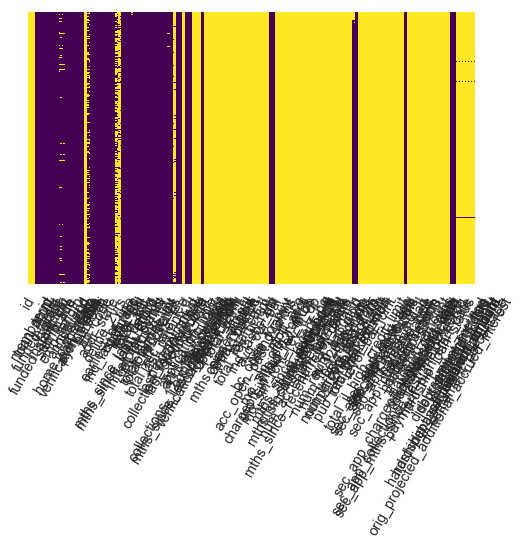

In [4]:
visualise_null(data)

In [5]:
data = data.dropna(axis='columns')

In [6]:
data.shape

(42506, 43)

### 15 appropriate features (see milestone proposal for info)

In [10]:

APPLICANT_NUMERIC = ['loan_amnt', 'annual_inc', 'dti', 'delinq_2yrs', 'pub_rec','revol_bal',
                    'open_acc', 'inq_last_6mths']

APPLICANT_CATEGORICAL = ['home_ownership', 'term', 'verification_status', 'purpose', 'zip_code', 'addr_state',
                        'earliest_cr_line']

LABEL = ['grade']

COLUMNS_USED = APPLICANT_NUMERIC + APPLICANT_CATEGORICAL + LABEL

In [11]:
data = data.loc[:, COLUMNS_USED]
data = data.reset_index(drop=True)
data.shape

(42506, 16)

In [20]:
df = data.copy()

## Encode categorical data into numeric

In [21]:
#One hot encoding
columns=['home_ownership', 'verification_status', 'purpose', 'addr_state', 'grade', 'term']

df = pd.get_dummies(df, columns=columns)

In [22]:

def data_encoding(df):
    if isinstance(df, pd.DataFrame):
        df['earliest_cr_line'] = [(datetime.datetime.now() - datetime.datetime.strptime(x, "%b-%y") ).total_seconds() for x in df['earliest_cr_line']]
        df['zip_code'] = [x[:-2] for x in df['zip_code']]

    else:
        TypeError("Required DataFrame")

In [23]:
data_encoding(df)

In [24]:
df.shape

(42506, 91)

In [25]:
df = df.apply(pd.to_numeric)


In [26]:
#Normalize
normalize_cols = ['loan_amnt', 
                    'annual_inc' ,                   
                    'dti',                    
                    'delinq_2yrs',                    
                    'pub_rec' ,                   
                    'revol_bal',                    
                    'open_acc'  ,                  
                    'inq_last_6mths'  ,                  
                    'zip_code' ,                   
                    'earliest_cr_line']

In [27]:
df[normalize_cols] = normalize(df[normalize_cols], axis=0)

In [28]:
df.head()

,loan_amnt,annual_inc,dti,delinq_2yrs,pub_rec,revol_bal,open_acc,inq_last_6mths,zip_code,earliest_cr_line,...,addr_state_WY,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,term_ 36 months,term_ 60 months
0,0.002727,0.001642,0.002145,0.0,0.0,0.0,0.000468,0.000000,0.001670,0.002623,...,0,0,0,1,0,0,0,0,1,0
1,0.001091,0.000741,0.000000,0.0,0.0,0.0,0.000468,0.000000,0.000170,0.002535,...,0,1,0,0,0,0,0,0,1,0
2,0.000727,0.000988,0.002248,0.0,0.0,0.0,0.000468,0.000000,0.006745,0.002501,...,0,0,1,0,0,0,0,0,1,0
3,0.000909,0.000562,0.002313,0.0,0.0,0.0,0.000468,0.002592,0.005440,0.004708,...,0,0,0,1,0,0,0,0,1,0
4,0.001363,0.000375,0.005608,0.0,0.0,0.0,0.000468,0.002592,0.004913,0.004445,...,0,0,0,0,0,0,1,0,1,0


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42506 entries, 0 to 42505
Data columns (total 91 columns):
loan_amnt                              42506 non-null float64
annual_inc                             42506 non-null float64
dti                                    42506 non-null float64
delinq_2yrs                            42506 non-null float64
pub_rec                                42506 non-null float64
revol_bal                              42506 non-null float64
open_acc                               42506 non-null float64
inq_last_6mths                         42506 non-null float64
zip_code                               42506 non-null float64
earliest_cr_line                       42506 non-null float64
home_ownership_MORTGAGE                42506 non-null uint8
home_ownership_NONE                    42506 non-null uint8
home_ownership_OTHER                   42506 non-null uint8
home_ownership_OWN                     42506 non-null uint8
home_ownership_RENT            

In [30]:
seed = 7
np.random.seed(seed)

In [31]:
col_y = ['grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G']

In [32]:
df_Y = df[col_y]
df_X =  df.drop(col_y, axis=1)

In [33]:
df_X.shape, df_Y.shape, df.shape

((42506, 84), (42506, 7), (42506, 91))

In [39]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=84, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [40]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=3, batch_size=100, verbose=0)

In [41]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [42]:
results = cross_val_score(estimator, df_X, df_Y, cv=kfold)


In [43]:
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 32.58% (0.70%)
